<a href="https://colab.research.google.com/github/mlites/mlites2019/blob/master/intro_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Linear Regression and Gradient Descent

Hello! In this exercise we'll peek behind the scenes at the deceptively simple linear regression algoritm by implementing a gradient descent algorithm

Along the way we'll learn to do some data manipulation in python using Pandas and NumPy, and learn how to separate our data into Training and Test sets for validation.

If you haven't already, make sure you run intro_kaggle.ipynb to download the necessary datasets


More background
* [Introduction to Machine Learning Algorithms: Linear Regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)

* [Quick start to Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)


## Outline

1. import necessary packages
2. Load Iditarod data
3. Do some date and time conversion
4. Generate some new features
5. Plot some data

## Getting Started

In [0]:
import pandas as pd #import Pandas under the shortcut 'pd'
import numpy as np #import NumPy; NumPy is the fundamental package for scientific computing with Python
import matplotlib.pyplot as plt #MatPlotLib is a plotting library

## Exploring the Iditarod Dataset

In [51]:
# first lets load the Iditarod data into a pandas dataframe in a variable called 'iditarod'

iditarod = pd.read_csv("iditarod.csv")
iditarod.tail()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,Arrival Date,Arrival Time,Arrival Dogs,Elapsed Time,Departure Date,Departure Time,Departure Dogs
1141,43,Jimmy Lebling,Rookie,United States,Nome,64.4964,-165.3996,22.0,2.95,7.46,03/18/2017,12:19:06,12.0,0.0,NaN,NaN,NaN
1142,47,Paul Hansen,Rookie,United States,Nome,64.4964,-165.3996,22.0,3.07,7.17,03/18/2017,14:19:11,12.0,0.0,NaN,NaN,NaN
1143,35,Alan Eischens,Veteran,United States,Nome,64.4964,-165.3996,22.0,3.50,6.29,03/18/2017,14:39:46,16.0,0.0,NaN,NaN,NaN
1144,53,Peter Reuter,Rookie,United States,Nome,64.4964,-165.3996,22.0,3.60,6.11,03/18/2017,14:45:38,9.0,0.0,NaN,NaN,NaN
1145,31,Cindy Abbott,Veteran,United States,Nome,64.4964,-165.3996,22.0,3.07,7.17,03/18/2017,14:57:31,12.0,0.0,NaN,NaN,NaN


Here we can see there is a bunch of data here about each musher, like when they arrived at each checkpoint, how long it took, what their speed was, and how many dogs they checked in or out

Let's explore the data a bit to see what it looks like. Say we're interested in how the number of dogs on the team affects the speed, we can plot that using the MatPlotLib library.

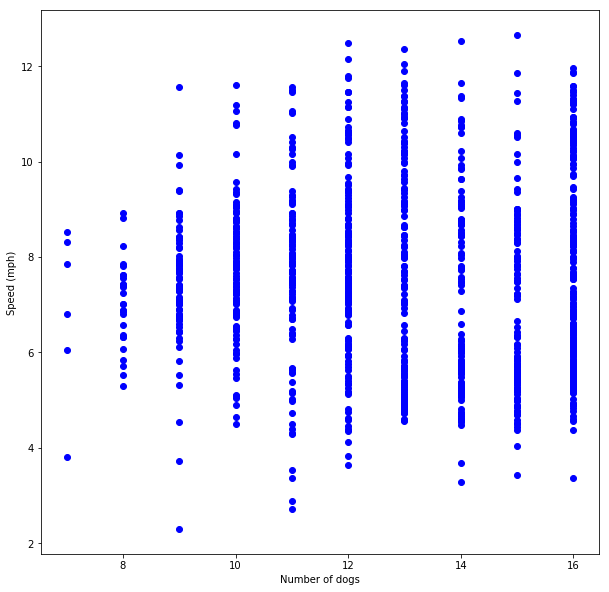

In [52]:
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod["Arrival Dogs"],iditarod["Speed"],color='blue') # the scatter command make a scatter plot
plt.xlabel("Number of dogs")
plt.ylabel("Speed (mph)")
plt.show()

What do you think, is there a trend?

Do mushers go faster when they have more dogs?

What other factors might affect their speed?

Let's the Date and Time into a single object, Datetime

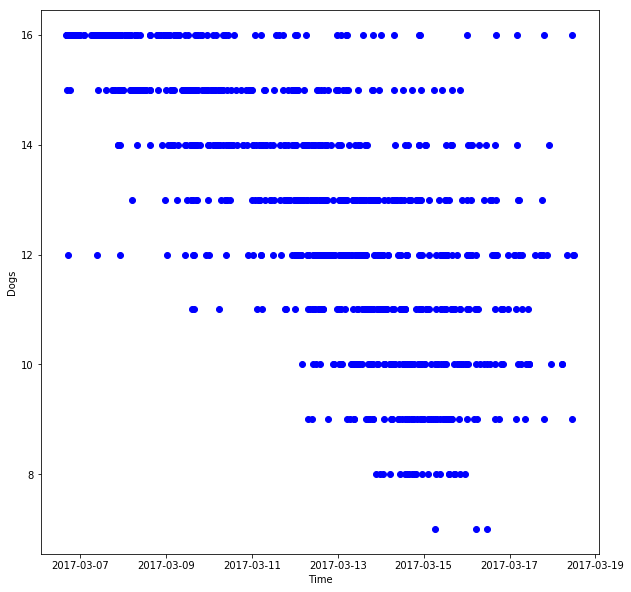

In [53]:

#let's drop values that have NA or NaN's
iditarod = iditarod.dropna()

#then convert the timestamps into a machine-readable timestamps

# import the datetime module
from datetime import datetime

# and get the Date and Time into a new dataframe

dt = iditarod.loc[:, ['Arrival Date', 'Arrival Time']] # : means 'all rows'

# this applies an anonymouse function ('lambda') to each row (axis=1) of the new dataframe
# that concatenates the Date and Time and converts them into a special 'datetime' object
# this then gets saved back into the iditarod dataframe

iditarod['Arrival_datetime'] = dt.apply(lambda x: datetime.strptime(x[0]+'/'+x[1], '%m/%d/%Y/%H:%M:%S'), axis=1)

# another way to make datetime objects in pandas
# iditarod["Arrival Time"] = pd.DatetimeIndex(iditarod["Arrival Time"],dtype='datetime64[ns]')
# iditarod["Departure Time"] = pd.DatetimeIndex(iditarod["Departure Time"],dtype='datetime64[ns]')

# now we can plot the number of Dogs as a function of the Datetime
# plot_data is a matplotlib command to use when you're plotting a date or time
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.plot_date(iditarod["Arrival_datetime"],iditarod["Arrival Dogs"],color='blue') #make a scatter plot
plt.xlabel("Time")
plt.ylabel("Dogs")
plt.show()


Is there a trend here?

It kind of looks like it, but how can we tell for sure?

Let's look at one more example.

In [61]:
# it might be nice to know the cumulative time and distance traveleled to each checkpoint

# we can find the unique checkpoints like this:
iditarod["Checkpoint"].unique()

# then from the Iditarod website we can find the cumulative distances
# https://iditarod.com/race-map/

# and input them into a new dictionary ('dict') like so:
cumulative_dist = {
'Fairbanks'	: 0,
'Nenana'	: 71,
'Manley'	: 161,
'Tanana'	: 227,
'Ruby'	: 346,
'Galena'	: 396,
'Huslia'	: 478,
'Koyukuk'	: 564,
'Nulato'	: 586,
'Kaltag'	: 633,
'Unalakleet'	: 718,
'Shaktoolik'	: 758,
'Koyuk'	: 808,
'Elim'	: 856,
'White Mountain'	: 902,
'Safety'	: 957,
'Nome'	: 979
}

# now we can the insert those into the iditarod dataframe using the 'replace' function like so:
iditarod["Distance_traveled"] = iditarod["Checkpoint"].replace(cumulative_dist)

# finally lets convert the timestamps into hours elapsed since the the start of the race
# we subtract the Arrival time from the race start time and use the .astype() function to report time difference in hours
# ok ok this isn't perfectly accurate because they actually do a 2-minute staggered start but I'll leave that as an exercise for the reader
racestart = pd.Timestamp('2017-03-06 11:00:00.00000')
iditarod["Elapsed_time"] = (iditarod["Arrival_datetime"]-racestart).astype('timedelta64[h]')

# now let's take a look at our new features
iditarod.head()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,...,Arrival Dogs,Elapsed Time,Departure Date,Departure Time,Departure Dogs,Arrival_datetime,Cumulative_distance,Cumulative_hours,Distance_traveled,Elapsed_time
72,6,Linwood Fiedler,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.05,11.88,...,16.0,3.93,03/06/2017,20:07:00,16.0,2017-03-06 16:11:00,71,5.0,71,5.0
73,5,Cody Strathe,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.22,11.50,...,16.0,0.12,03/06/2017,16:26:00,16.0,2017-03-06 16:19:00,71,5.0,71,5.0
74,4,Misha Wiljes,Rookie,Czech Republic,Nenana,64.5952,-149.0897,60.0,5.25,11.43,...,15.0,5.93,03/06/2017,22:15:00,15.0,2017-03-06 16:19:00,71,5.0,71,5.0
75,9,Michelle Phillips,Veteran,Canada,Nenana,64.5952,-149.0897,60.0,5.18,11.58,...,16.0,3.48,03/06/2017,19:54:00,16.0,2017-03-06 16:25:00,71,5.0,71,5.0
76,15,Martin Buser,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.02,11.96,...,16.0,0.23,03/06/2017,16:41:00,16.0,2017-03-06 16:27:00,71,5.0,71,5.0


Ok, your turn!

Fill in the missing details to make a scatter plot of the elapsed time as a function of the distance traveled

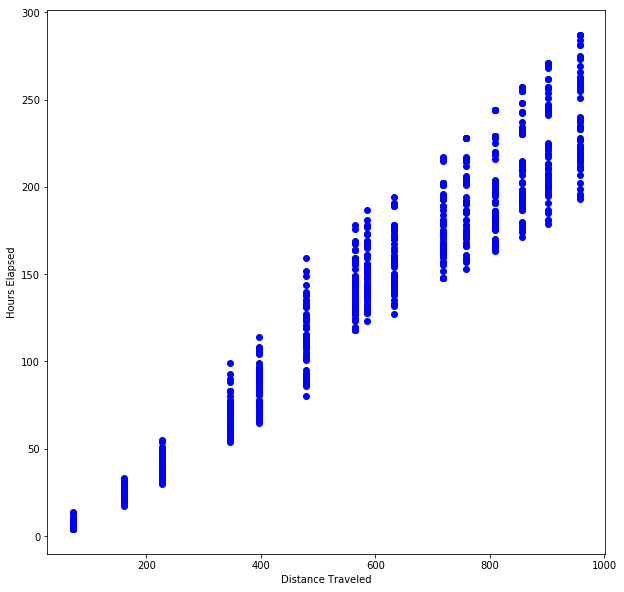

In [57]:
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod[""],iditarod[""],color='blue') #make a scatter plot
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")
plt.show()

## Introducing Training and Testing Sets

In Machine Learning, the way we validate how well the machines are learning is by using two subsets of any given dataset: a Train set, and a Test set. Usually we'll split the data 80/20 between these subsets and thus use 80% of the data to Train our model, and 20% to Test whether our predictions are any good.


**Some questions for you:**

* Why don't we train on the whole data set?
* Wouldn't we get a better model that way?
* Think about the answers and we'll come back to it later.

First, let's work with the Elapsed Time and Distance Traveled data, and split it into Train and Test sets.

We'll use scikit-learn, a basic but powerful machine learning toolkit for python.

docs: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [0]:
import sklearn #import the scikit-learn package
from sklearn.model_selection import train_test_split #import the 

x = iditarod["Distance_traveled"]
y = iditarod["Elapsed_time"]

# here we tell sklearn to split our data and reserve 20% for the test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# need to convert data to numpy array and reshape data for input into linear model 
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)



In [81]:
from sklearn.linear_model import LinearRegression # import the LinearRegression module from sklearn
from sklearn.metrics import r2_score # import the r2_score module from sklearn

clf = LinearRegression() # initiate an object of Class LinearRegression
clf.fit(x_train,y_train) # call the .fit function to fit the training data x_train and y_train

[279.69106422]


Now that we have a model trained on the training set, we can use it to predict new values.

For example, if the Iditarod was 1100 miles long instead of 1000, how many hours would it take the average musher to finish?


In [113]:
y_pred = clf.predict([[1100]]) # we need double brackets because .predict expects an array of arrays
print(y_pred[0]) # [0] to access the first value in the y_pred array

279.69106421579426


Let's print out the formula for our best fit line using the coefficients found within the 'clf' object

In [114]:
# the formula for the best fit line is
slope = clf.coef_[0]
intercept = clf.intercept_
print("y = " + str(slope) + "x" + " + " + str(intercept)) #str() converts a numeric to a string

# get control of those significant figures by printing with nicer formatting
print("y = %.2fx + %.2f" % (slope, intercept)) # %.2f says to format a _f_loating-point number to 2 decimal places

y = 0.26849998873152303x + -15.658923388881078
y = 0.27x + -15.66


Now let's plot the best fit line over the training and testing data

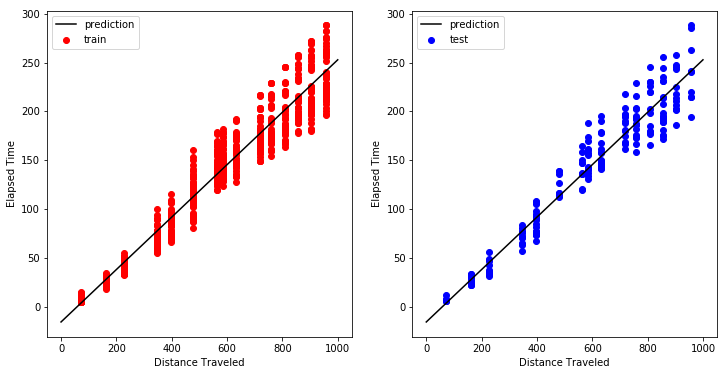

In [115]:
x_fit = np.linspace(0,1000, 50) # linspace(start, stop, num) generates a linearly-spaced numeric array
y_fit = slope*x_fit + intercept

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1) #subplot(nrows, ncols, index) allows for multiple plots on one page
plt.scatter(x_train,y_train,color='red',label='train')
plt.plot(x_fit,y_fit,color='black',label = 'prediction')
plt.legend()
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")

plt.subplot(1, 2, 2)
plt.scatter(x_test,y_test,color='blue',label='test')
plt.plot(x_fit,y_fit,color='black',label = 'prediction')
plt.legend()
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")

plt.show()

In [0]:
y_prediction = a_0 + a_1 * x_test
print('R2 Score:',r2_score(y_test,y_prediction))

y_plot = []
for i in range(100):
    y_plot.append(a_0 + a_1 * i)
plt.figure(figsize=(10,10))
plt.scatter(x_test,y_test,color='red',label='GT')
plt.plot(range(len(y_plot)),y_plot,color='black',label = 'pred')
plt.legend()
plt.show()

In [0]:
## Linear Regression 
import numpy as np

n = 700
alpha = 0.0001

a_0 = np.zeros((n,1))
a_1 = np.zeros((n,1))

epochs = 0
while(epochs < 1000):
    y = a_0 + a_1 * x_train
    error = y - y_train
    mean_sq_er = np.sum(error**2)
    mean_sq_er = mean_sq_er/n
    a_0 = a_0 - alpha * 2 * np.sum(error)/n 
    a_1 = a_1 - alpha * 2 * np.sum(error * x_train)/n
    epochs += 1
    if(epochs%10 == 0):
        print(mean_sq_er)